## <center> `Spam Detection Using Fine-Tuned BERT` </center>

`Dataset:`
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

`Objective:`
Build an AI model that can classify messages as spam or legitimate using BERT model


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1. [Loading Data](#1)
2. [Data Preparation](#2)
3. [Exploratory Data Analysis (EDA)](#3)
4. [Original Data](#4)
   1. [Train/Test Splitting](#4.1)
   2. [Model Building](#4.2)
   3. [Model Evaluation](#4.3)
5. [Hyperparameter Tuning with Keras Tuner (Original Data)](#5)
   1. [Model Building](#5.1)
   2. [Model Evaluation](#5.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#5.3)
6. [Downsampling Data](#6)
   1. [Train/Test Splitting](#6.1)
   2. [Model Building](#6.2)
   3. [Model Evaluation](#6.3)
7. [Hyperparameter Tuning with Keras Tuner (Downsampled Data)](#7)
   1. [Model Building](#7.1)
   2. [Model Evaluation](#7.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#7.3)
8. [Upsampling Data](#8)
   1. [Train/Test Splitting](#8.1)
   2. [Model Building](#8.2)
   3. [Model Evaluation](#8.3)
9. [Hyperparameter Tuning with Keras Tuner (Upsampled Data)](#9)
   1. [Model Building](#9.1)
   2. [Model Evaluation](#9.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#9.3)
10. [Class Weights](#10)
    1. [Model Building](#10.1)
    2. [Model Evaluation](#10.2)
11. [Hyperparameter Tuning with Keras Tuner (Class Weights)](#11)
    1. [Model Building](#11.1)
    2. [Model Evaluation](#11.2)
    3. [Additional Metrics (ROC-AUC) for BERT](#11.3)
12. [Custom Loss](#12)
    1. [Model Building](#12.1)
    2. [Model Evaluation](#12.2)
13. [Hyperparameter Tuning with Keras Tuner (Custom Loss)](#13)
    1. [Model Building](#13.1)
    2. [Model Evaluation](#13.2)
    3. [Additional Metrics (ROC-AUC) for BERT](#13.3)
14. [Performance Comparison of Fine-Tuned BERT](#14)
15. [Performance Comparison of Hyperparameter-Tuned BERT](#15)
16. [Inference Comparison of Fine-Tuned BERT](#16)
17. [Inference Comparison of Hyperparameter-Tuned BERT](#17)
18. [Conclusion](#18)
19. [Deployment](#19)
20. [References](#20)

## Loading Data
<a class="anchor" id="1"></a>
[Table of Contents](#0.1)

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import os
import joblib
import warnings #ignore warning
warnings.filterwarnings("ignore")

In [2]:
# Define file path
filepath ="D://Portfolio//Internship//AFAME//Project details//Spam SMS Detection//spam.csv"
# Read the CSV file into a DataFrame with specified encoding
data = pd.read_csv(filepath, encoding='latin1')
# Display the first few rows of the DataFrame
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Preparation
<a class="anchor" id="2"></a>
[Table of Contents](#0.1)

In [4]:
# removing excess unnecessary column 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)

In [6]:
data['Class'] = data['Class'].map({'ham':0, 'spam':1})
data.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Checking null values
data.isnull().sum()

Class    0
Text     0
dtype: int64

In [8]:
data.duplicated().sum()

403

We are retaining the duplicate values as they are crucial for our task of identifying spam SMS messages.

In [9]:
# Viewing values in 'v1' column
data['Class'].value_counts()

Class
0    4825
1     747
Name: count, dtype: int64

In [10]:
data.groupby('Class').describe()

Text                                                               
      count unique                                                top freq
Class                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [11]:
# Viewing the imbalanced rate
747/4825

0.15481865284974095

In [12]:
# Viewing unique values in 'v2'
data['Text'].nunique()

5169

## Exploratory Data Analysis (EDA)
<a class="anchor" id="3"></a>
[Table of Contents](#0.1)

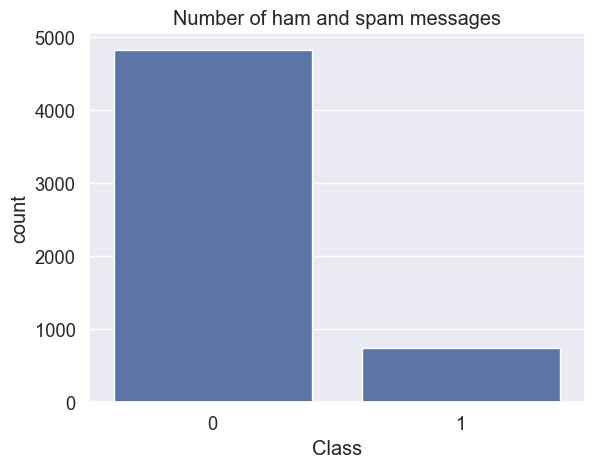

In [13]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(data=data, x= 'Class').set_title("Number of ham and spam messages")
plt.show()

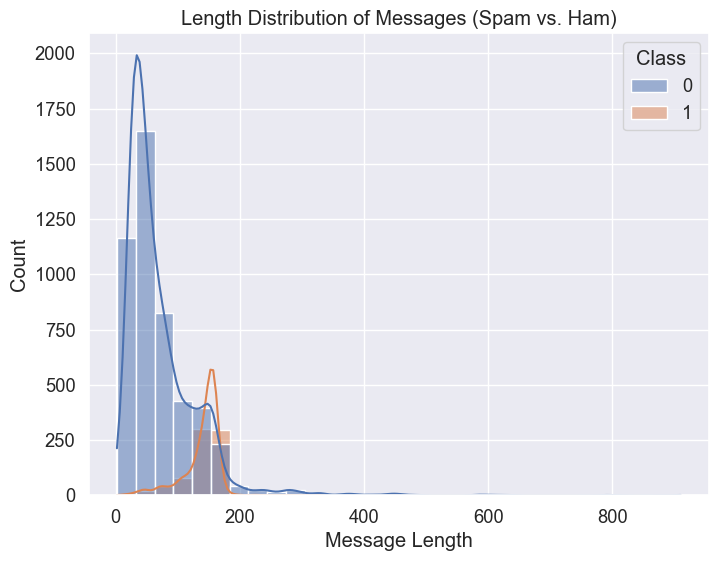

In [14]:
# Plot the distribution of message lengths
plt.figure(figsize=(8, 6))
sns.histplot(x=data['Text'].str.len(), bins=30, hue=data['Class'], kde=True)
plt.title('Length Distribution of Messages (Spam vs. Ham)')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

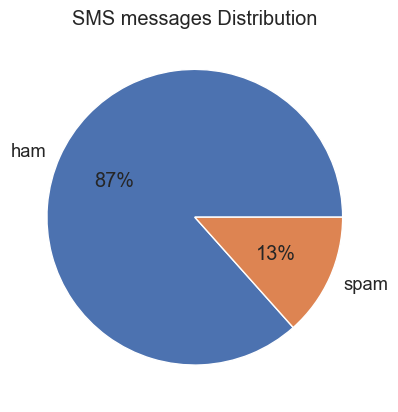

In [15]:
sms = pd.value_counts(data["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

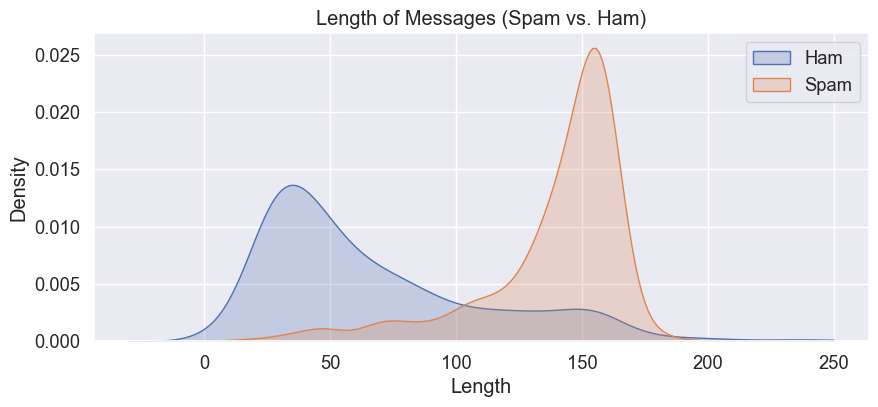

In [16]:
# Calculate lengths of messages directly in the plotting function
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(data.loc[data.Class == 0, 'Text'].str.len(), shade=True, label='Ham', clip=(-50, 250))
sns.kdeplot(data.loc[data.Class == 1, 'Text'].str.len(), shade=True, label='Spam', clip=(-50, 250))

# Set axis labels and title
ax.set(
    xlabel='Length',
    ylabel='Density',
    title='Length of Messages (Spam vs. Ham)'
)
ax.legend(loc='upper right')

# Show plot
plt.show()

## Original Data
<a class="anchor" id="4"></a>
[Table of Contents](#0.1)

### Train/Test Spliting
<a class="anchor" id="4.1"></a>
[Table of Contents](#0.1)

In [17]:
X = data['Text']
y = data['Class']

In [18]:
X.shape

(5572,)

In [19]:
y.shape

(5572,)

In [20]:
print(f'Length of X: {len(X)}')
print(f'Length of y: {len(y)}')

Length of X: 5572
Length of y: 5572


In [21]:
from sklearn.model_selection import train_test_split
random_seed = 42

# Split data into training and temporary sets (60% train, 40% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify = y)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify = y_temp)

print(f'Training data: {len(X_train)}, {len(y_train)}')
print(f'Validation data: {len(X_val)}, {len(y_val)}') 
print(f'Testing data: {len(X_test)}, {len(y_test)}') 

Training data: 3900, 3900
Validation data: 836, 836
Testing data: 836, 836


## Model Building
<a class="anchor" id="4.2"></a>
[Table of Contents](#0.1)

In [22]:
%%time
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3') # loading Bert Preprocessor
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4') # Loading Bert Encoder

CPU times: total: 9.64 s
Wall time: 13.9 s


In [23]:
%%time
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  # Import the optimizer

# Functional BERT layers
text_input = Input(shape=(), dtype=tf.string, name='Inputs')
encoder_inputs = bert_preprocessor(text_input)
embbed = bert_encoder(encoder_inputs)

# Neural Network layers
dropout1 = Dropout(0.1, name='Dropout1')(embbed['pooled_output'])
dense1 = Dense(128, activation='relu', name='Dense1')(dropout1)
batch_norm1 = BatchNormalization(name='BatchNorm1')(dense1)
dropout2 = Dropout(0.1, name='Dropout2')(batch_norm1)
dense2 = Dense(64, activation='relu', name='Dense2')(dropout2)
batch_norm2 = BatchNormalization(name='BatchNorm2')(dense2)
dropout3 = Dropout(0.1, name='Dropout3')(batch_norm2)
outputs = Dense(1, activation='sigmoid', name='Output')(dropout3)

# Creating final model
model = Model(inputs=[text_input], outputs=[outputs])

CPU times: total: 438 ms
Wall time: 616 ms


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [25]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = metrics)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, 
                               restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.2, 
                                 patience=2, 
                                 min_lr=1e-7)

In [27]:
%%time
# Fit the model
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 71s 499ms/step - loss: 0.4288 - accuracy: 0.8308 - precision: 0.4365 - recall: 0.9006 - val_loss: 0.2376 - val_accuracy: 0.9426 - val_precision: 0.9571 - val_recall: 0.5982 - lr: 0.0010
Epoch 2/20
122/122 [==============================] - 60s 490ms/step - loss: 0.1779 - accuracy: 0.9518 - precision: 0.7787 - recall: 0.8948 - val_loss: 0.1249 - val_accuracy: 0.9533 - val_precision: 1.0000 - val_recall: 0.6518 - lr: 0.0010
Epoch 3/20
122/122 [==============================] - 60s 490ms/step - loss: 0.1232 - accuracy: 0.9618 - precision: 0.8555 - recall: 0.8604 - val_loss: 0.0707 - val_accuracy: 0.9797 - val_precision: 0.9612 - val_recall: 0.8839 - lr: 0.0010
Epoch 4/20
122/122 [==============================] - 60s 490ms/step - loss: 0.1058 - accuracy: 0.9672 - precision: 0.8926 - recall: 0.8585 - val_loss: 0.1003 - val_accuracy: 0.9701 - val_precision: 0.8480 - val_recall: 0.9464 - lr: 0.0010
Epoch 5/20
122/122 [====================

## Model Evaluation
<a class="anchor" id="4.3"></a>
[Table of Contents](#0.1)

In [28]:
# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

27/27 [==============================] - 11s 412ms/step - loss: 0.0418 - accuracy: 0.9904 - precision: 0.9815 - recall: 0.9464
Test Loss: 0.04175851494073868
Test Accuracy: 0.9904305934906006


In [29]:
y_predict = model.predict(X_test)
y_predict = y_predict.flatten()

27/27 [==============================] - 12s 414ms/step


In [30]:
y_predict = np.where(y_predict > 0.5,1,0)
y_predict

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
cm

array([[722,   2],
       [  6, 106]], dtype=int64)

Text(43.25, 0.5, 'Actual')

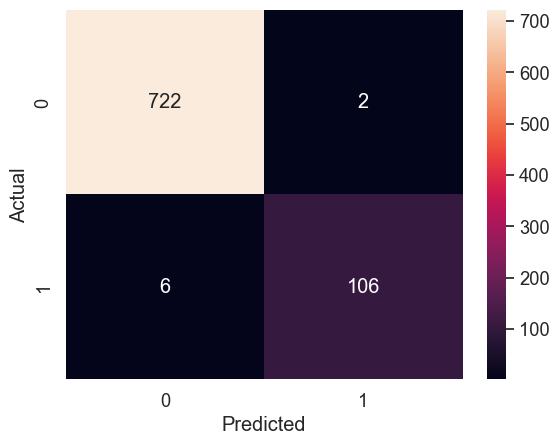

In [32]:
sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [33]:
from sklearn.metrics import classification_report

nml = classification_report(y_test, y_predict, target_names=['Ham', 'Spam'])
print(nml)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       724
        Spam       0.98      0.95      0.96       112

    accuracy                           0.99       836
   macro avg       0.99      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



## Inference

In [34]:
# Actual real examples
reviews = [
    'You will be hired at managerial roles in top companies',
    'Citrusbug Technolabs is hiring for AI/ML Engineer + 14 new Fresher Data Science jobs',
    'Job opportunity from Wipro just for You!',
    'Dear Congratulations - Get Your Job Offer Letter @ Cognizant',
    'Practice Coding with A Very Big Sum'
]

# Detection of examples
nml_inf = model.predict(reviews)
nml_inf

1/1 [==============================] - 1s 897ms/step


array([[0.02774307],
       [0.46297142],
       [0.15588982],
       [0.4203427 ],
       [0.00780586]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Original Data)
<a class="anchor" id="5"></a>
[Table of Contents](#0.1)

In [35]:
%%time
import kerastuner as kt

# Function to compile your existing model with hyperparameters
def compile_model(hp):
    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model with the chosen learning rate
    model.compile(optimizer = Adam(learning_rate=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics = metrics)
    return model

# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='nml_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_nml = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\nml_model\tuner0.json
CPU times: total: 766 ms
Wall time: 1.75 s


In [36]:
# Evaluate the best model on the validation set
hp_results_val = best_model_nml.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val[0]}")
print(f"Validation Accuracy: {hp_results_val[1]}")

27/27 [==============================] - 12s 409ms/step - loss: 0.0464 - accuracy: 0.9868 - precision: 0.9720 - recall: 0.9286

Validation Loss: 0.046408411115407944
Validation Accuracy: 0.9868420958518982


In [37]:
# Evaluate the best model on the test set
hp_results_test = best_model_nml.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test[0]}")
print(f"Test Accuracy: {hp_results_test[1]}")

27/27 [==============================] - 11s 413ms/step - loss: 0.0403 - accuracy: 0.9916 - precision: 0.9817 - recall: 0.9554
\Test Loss: 0.040296293795108795
Test Accuracy: 0.9916267991065979


## Model Building
<a class="anchor" id="5.1"></a>
[Table of Contents](#0.1)

In [38]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_nml.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 69s 541ms/step - loss: 0.0681 - accuracy: 0.9767 - precision: 0.9337 - recall: 0.8891 - val_loss: 0.0484 - val_accuracy: 0.9844 - val_precision: 0.9304 - val_recall: 0.9554 - lr: 1.0000e-04
Epoch 2/20
122/122 [==============================] - 65s 532ms/step - loss: 0.0687 - accuracy: 0.9756 - precision: 0.9280 - recall: 0.8872 - val_loss: 0.0435 - val_accuracy: 0.9844 - val_precision: 0.9806 - val_recall: 0.9018 - lr: 1.0000e-04
Epoch 3/20
122/122 [==============================] - 65s 537ms/step - loss: 0.0689 - accuracy: 0.9769 - precision: 0.9339 - recall: 0.8910 - val_loss: 0.0423 - val_accuracy: 0.9844 - val_precision: 0.9806 - val_recall: 0.9018 - lr: 1.0000e-04
Epoch 4/20
122/122 [==============================] - 65s 533ms/step - loss: 0.0689 - accuracy: 0.9754 - precision: 0.9261 - recall: 0.8872 - val_loss: 0.0417 - val_accuracy: 0.9844 - val_precision: 0.9806 - val_recall: 0.9018 - lr: 1.0000e-04
Epoch 5/20
122/122 [====

## Model Evaluation
<a class="anchor" id="5.2"></a>
[Table of Contents](#0.1)

In [39]:
y_predict_hp = best_model_nml.predict(X_test)
y_predict_hp = y_predict_hp.flatten()

27/27 [==============================] - 12s 421ms/step


In [40]:
y_predict_hp = np.where(y_predict_hp > 0.5,1,0)
y_predict_hp

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [41]:
cm_hp = confusion_matrix(y_test, y_predict_hp)
cm_hp

array([[722,   2],
       [  7, 105]], dtype=int64)

Text(43.25, 0.5, 'Actual')

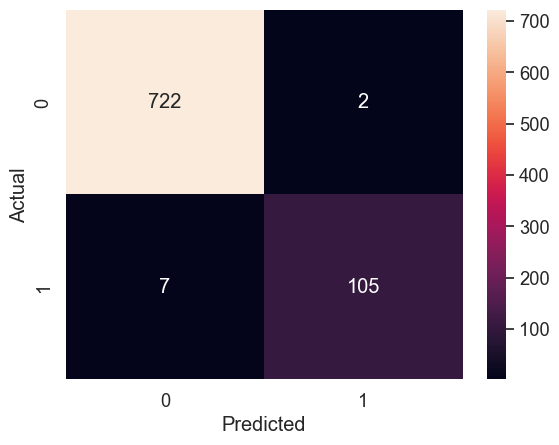

In [42]:
sns.heatmap(cm_hp, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [43]:
nml_hp = classification_report(y_test, y_predict_hp, target_names=['Ham', 'Spam'])
print(nml_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       724
        Spam       0.98      0.94      0.96       112

    accuracy                           0.99       836
   macro avg       0.99      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="5.3"></a>
[Table of Contents](#0.1)

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_test = roc_auc_score(y_test, y_predict_hp)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9674


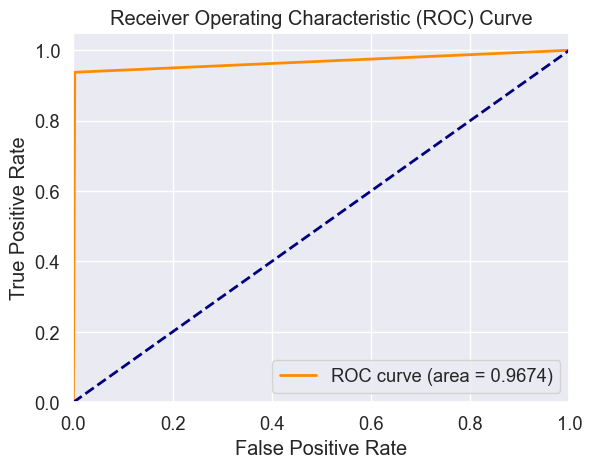

In [45]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [46]:
# Detection of examples
nml_inf_hp = best_model_nml.predict(reviews)
nml_inf_hp

1/1 [==============================] - 1s 921ms/step


array([[0.02172732],
       [0.39693063],
       [0.2005491 ],
       [0.35874367],
       [0.00429705]], dtype=float32)

## Downsampling Data
<a class="anchor" id="6"></a>
[Table of Contents](#0.1)

In [47]:
data_dwn = data.copy(deep=True)

In [48]:
data_dwn.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [49]:
data_spam = data_dwn[data_dwn['Class']==1]
data_spam.shape

(747, 2)

In [50]:
data_ham = data_dwn[data_dwn['Class']==0]
data_ham.shape

(4825, 2)

In [51]:
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(747, 2)

In [52]:
data_balanced_dwn = pd.concat([data_spam,data_ham_downsampled])
data_balanced_dwn.shape

(1494, 2)

In [53]:
data_balanced_dwn['Class'].value_counts()

Class
1    747
0    747
Name: count, dtype: int64

## Train/Test Splitting
<a class="anchor" id="6.1"></a>
[Table of Contents](#0.1)

In [54]:
X_dwn = data_balanced_dwn['Text']
y_dwn = data_balanced_dwn['Class']

In [55]:
# Split data into training and temporary sets (60% train, 40% temp)
X_train_dwn, X_temp_dwn, y_train_dwn, y_temp_dwn = train_test_split(X_dwn, y_dwn, test_size=0.3, random_state=random_seed, stratify = y_dwn)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val_dwn, X_test_dwn, y_val_dwn, y_test_dwn = train_test_split(X_temp_dwn, y_temp_dwn, test_size=0.5, random_state=random_seed, stratify = y_temp_dwn)

print(f'Training data: {len(X_train_dwn)}, {len(y_train_dwn)}')
print(f'Validation data: {len(X_val_dwn)}, {len(y_val_dwn)}') 
print(f'Testing data: {len(X_test_dwn)}, {len(y_test_dwn)}') 

Training data: 1045, 1045
Validation data: 224, 224
Testing data: 225, 225


## Model Building
<a class="anchor" id="6.2"></a>
[Table of Contents](#0.1)

In [56]:
%%time
# Fit the model
history_dwn = model.fit(X_train_dwn, y_train_dwn, epochs=20, 
                    validation_data=(X_val_dwn, y_val_dwn), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
33/33 [==============================] - 18s 534ms/step - loss: 0.7489 - accuracy: 0.7522 - precision: 1.0000 - recall: 0.5048 - val_loss: 0.1234 - val_accuracy: 0.9554 - val_precision: 1.0000 - val_recall: 0.9107 - lr: 2.0000e-05
Epoch 2/20
33/33 [==============================] - 17s 517ms/step - loss: 0.7105 - accuracy: 0.7732 - precision: 1.0000 - recall: 0.5468 - val_loss: 0.1597 - val_accuracy: 0.9330 - val_precision: 1.0000 - val_recall: 0.8661 - lr: 2.0000e-05
Epoch 3/20
33/33 [==============================] - 17s 519ms/step - loss: 0.6482 - accuracy: 0.7876 - precision: 1.0000 - recall: 0.5755 - val_loss: 0.1856 - val_accuracy: 0.9241 - val_precision: 1.0000 - val_recall: 0.8482 - lr: 2.0000e-05
Epoch 4/20
33/33 [==============================] - 17s 524ms/step - loss: 0.6164 - accuracy: 0.8038 - precision: 0.9969 - recall: 0.6099 - val_loss: 0.2278 - val_accuracy: 0.9196 - val_precision: 1.0000 - val_recall: 0.8393 - lr: 4.0000e-06
CPU times: total: 49.2 s
Wall ti

### Model Evaluation
<a class="anchor" id="6.3"></a>
[Table of Contents](#0.1)

In [57]:
# Evaluate the model
results_dwn = model.evaluate(X_test_dwn, y_test_dwn)
print(f"Test Loss: {results_dwn[0]}")
print(f"Test Accuracy: {results_dwn[1]}")

8/8 [==============================] - 3s 376ms/step - loss: 0.1270 - accuracy: 0.9600 - precision: 1.0000 - recall: 0.9196
Test Loss: 0.12701144814491272
Test Accuracy: 0.9599999785423279


In [58]:
y_predict_dwn = model.predict(X_test_dwn)
y_predict_dwn = y_predict_dwn.flatten()

8/8 [==============================] - 3s 418ms/step


In [59]:
y_predict_dwn = np.where(y_predict_dwn > 0.5,1,0)
y_predict_dwn

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1])

In [60]:
cm_dwn = confusion_matrix(y_test_dwn, y_predict_dwn)
cm_dwn

array([[113,   0],
       [  9, 103]], dtype=int64)

Text(43.25, 0.5, 'Actual')

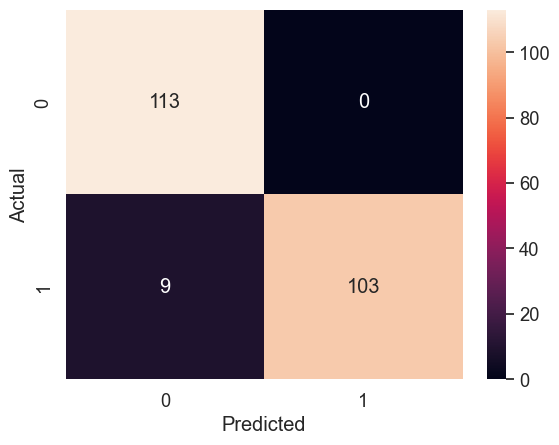

In [61]:
sns.heatmap(cm_dwn, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [62]:
dwn = classification_report(y_test_dwn, y_predict_dwn, target_names=['Ham', 'Spam'])
print(dwn)

              precision    recall  f1-score   support

         Ham       0.93      1.00      0.96       113
        Spam       1.00      0.92      0.96       112

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225



In [63]:
# Detection of examples
dwn_inf = model.predict(reviews)
dwn_inf

1/1 [==============================] - 0s 47ms/step


array([[0.00748722],
       [0.21018825],
       [0.08766864],
       [0.2078424 ],
       [0.00202337]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Downsampled Data)
<a class="anchor" id="7"></a>
[Table of Contents](#0.1)

In [64]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='dwn_model'
)

# Perform hyperparameter tuning
tuner.search(X_train_dwn, y_train_dwn, epochs=5, validation_data=(X_val_dwn, y_val_dwn))

# Get the best model
best_model_dwn = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\dwn_model\tuner0.json
CPU times: total: 828 ms
Wall time: 1.65 s


In [65]:
# Evaluate the best model on the validation set
hp_results_val_dwn = best_model_dwn.evaluate(X_val_dwn, y_val_dwn)
print(f"\nValidation Loss: {hp_results_val[0]}")
print(f"Validation Accuracy: {hp_results_val[1]}")

7/7 [==============================] - 4s 423ms/step - loss: 0.0493 - accuracy: 0.9733 - precision: 0.9953 - recall: 0.9509

Validation Loss: 0.046408411115407944
Validation Accuracy: 0.9868420958518982


In [66]:
# Evaluate the best model on the Test set
hp_results_test_dwn = best_model_dwn.evaluate(X_test_dwn, y_test_dwn)
print(f"\Test Loss: {hp_results_test_dwn[0]}")
print(f"Test Accuracy: {hp_results_test_dwn[1]}")

8/8 [==============================] - 4s 372ms/step - loss: 0.1388 - accuracy: 0.9511 - precision: 0.9391 - recall: 0.9643
\Test Loss: 0.13879336416721344
Test Accuracy: 0.9511111378669739


## Model Building
<a class="anchor" id="7.1"></a>
[Table of Contents](#0.1)

In [67]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_dwn.fit(X_train_dwn, y_train_dwn, epochs=20, 
                    validation_data=(X_val_dwn, y_val_dwn), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
33/33 [==============================] - 21s 547ms/step - loss: 0.2156 - accuracy: 0.9359 - precision: 0.9831 - recall: 0.8872 - val_loss: 0.7917 - val_accuracy: 0.7411 - val_precision: 0.6588 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/20
33/33 [==============================] - 17s 525ms/step - loss: 0.1898 - accuracy: 0.9349 - precision: 0.9577 - recall: 0.9101 - val_loss: 0.1175 - val_accuracy: 0.9598 - val_precision: 0.9328 - val_recall: 0.9911 - lr: 0.0010
Epoch 3/20
33/33 [==============================] - 17s 528ms/step - loss: 0.1424 - accuracy: 0.9608 - precision: 0.9671 - recall: 0.9541 - val_loss: 0.0829 - val_accuracy: 0.9777 - val_precision: 0.9908 - val_recall: 0.9643 - lr: 0.0010
Epoch 4/20
33/33 [==============================] - 17s 527ms/step - loss: 0.1279 - accuracy: 0.9627 - precision: 0.9672 - recall: 0.9579 - val_loss: 0.0738 - val_accuracy: 0.9777 - val_precision: 0.9820 - val_recall: 0.9732 - lr: 0.0010
Epoch 5/20
33/33 [==============================

## Model Evaluation
<a class="anchor" id="7.2"></a>
[Table of Contents](#0.1)

In [68]:
y_predict_hp_dwn = best_model_dwn.predict(X_test_dwn)
y_predict_hp_dwn = y_predict_hp_dwn.flatten()

8/8 [==============================] - 4s 416ms/step


In [69]:
y_predict_hp_dwn = np.where(y_predict_hp_dwn > 0.5,1,0)
y_predict_hp_dwn

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1])

In [70]:
cm_hp_dwn = confusion_matrix(y_test_dwn, y_predict_hp_dwn)
cm_hp_dwn

array([[110,   3],
       [  5, 107]], dtype=int64)

Text(43.25, 0.5, 'Actual')

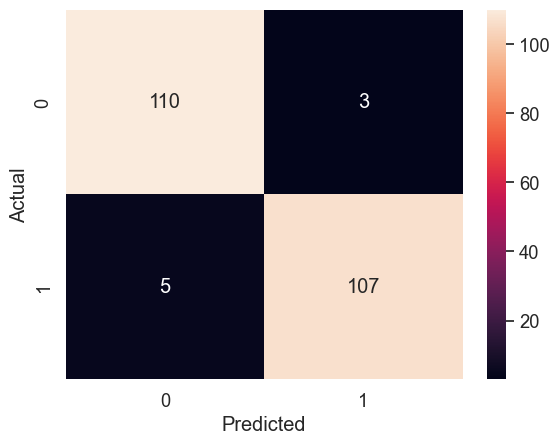

In [71]:
sns.heatmap(cm_hp_dwn, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [72]:
dwn_hp = classification_report(y_test_dwn, y_predict_hp_dwn, target_names=['Ham', 'Spam'])
print(dwn_hp)

              precision    recall  f1-score   support

         Ham       0.96      0.97      0.96       113
        Spam       0.97      0.96      0.96       112

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="7.3"></a>
[Table of Contents](#0.1)

In [73]:
roc_auc_test = roc_auc_score(y_test_dwn, y_predict_hp_dwn)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9644


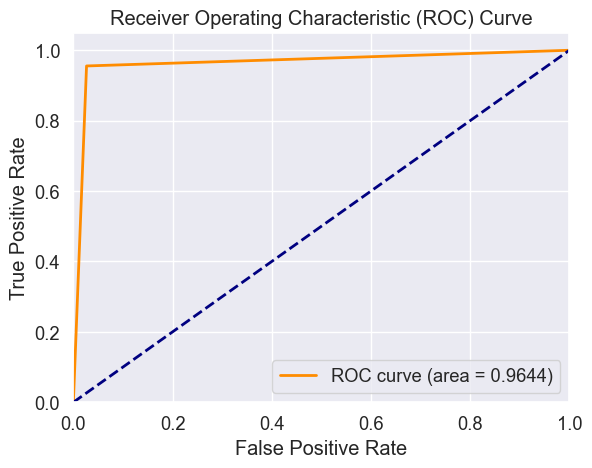

In [74]:
# y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test_dwn, y_predict_hp_dwn)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [75]:
# Detection of examples
dwn_inf_hp = best_model_dwn.predict(reviews)
dwn_inf_hp

1/1 [==============================] - 1s 839ms/step


array([[0.04702015],
       [0.44492415],
       [0.8023651 ],
       [0.7688524 ],
       [0.00090111]], dtype=float32)

## Upsampling Data
<a class="anchor" id="8"></a>
[Table of Contents](#0.1)

In [76]:
data_up = data.copy(deep=True)
data_up

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [77]:
data_spam_up = data_up[data_up['Class']==1]
data_spam_up.shape

(747, 2)

In [78]:
data_ham_up = data_up[data_up['Class']==0]
data_ham_up.shape

(4825, 2)

In [79]:
data_spam_upsampled = data_spam_up.sample(data_ham_up.shape[0], replace=True)
data_spam_upsampled.shape

(4825, 2)

In [80]:
data_balanced_up = pd.concat([data_ham_up,data_spam_upsampled])
data_balanced_up.shape

(9650, 2)

In [81]:
data_balanced_up['Class'].value_counts()

Class
0    4825
1    4825
Name: count, dtype: int64

## Train/Test Splitting
<a class="anchor" id="8.1"></a>
[Table of Contents](#0.1)

In [82]:
X_up = data_balanced_up['Text']
y_up = data_balanced_up['Class']

In [83]:
# Split data into training and temporary sets (60% train, 40% temp)
X_train_up, X_temp_up, y_train_up, y_temp_up = train_test_split(X_up, y_up, test_size=0.3, random_state=random_seed, stratify = y_up)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val_up, X_test_up, y_val_up, y_test_up = train_test_split(X_temp_up, y_temp_up, test_size=0.5, random_state=random_seed, stratify = y_temp_up)

print(f'Training data: {len(X_train_up)}, {len(y_train_up)}')
print(f'Validation data: {len(X_val_up)}, {len(y_val_up)}') 
print(f'Testing data: {len(X_test_up)}, {len(y_test_up)}') 

Training data: 6755, 6755
Validation data: 1447, 1447
Testing data: 1448, 1448


## Model Building
<a class="anchor" id="8.2"></a>
[Table of Contents](#0.1)

In [84]:
%%time
# Fit the model
history_up = model.fit(X_train_up, y_train_up, epochs=20, 
                    validation_data=(X_val_up, y_val_up), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
212/212 [==============================] - 111s 522ms/step - loss: 0.1430 - accuracy: 0.9560 - precision: 0.9622 - recall: 0.9494 - val_loss: 0.0633 - val_accuracy: 0.9786 - val_precision: 0.9613 - val_recall: 0.9972 - lr: 2.0000e-04
Epoch 2/20
212/212 [==============================] - 109s 516ms/step - loss: 0.1374 - accuracy: 0.9560 - precision: 0.9573 - recall: 0.9547 - val_loss: 0.0504 - val_accuracy: 0.9834 - val_precision: 0.9768 - val_recall: 0.9903 - lr: 2.0000e-04
Epoch 3/20
212/212 [==============================] - 110s 521ms/step - loss: 0.1221 - accuracy: 0.9587 - precision: 0.9605 - recall: 0.9568 - val_loss: 0.0529 - val_accuracy: 0.9786 - val_precision: 0.9873 - val_recall: 0.9696 - lr: 2.0000e-04
Epoch 4/20
212/212 [==============================] - 111s 525ms/step - loss: 0.1245 - accuracy: 0.9585 - precision: 0.9586 - recall: 0.9586 - val_loss: 0.0444 - val_accuracy: 0.9869 - val_precision: 0.9848 - val_recall: 0.9889 - lr: 2.0000e-04
Epoch 5/20
212/212 [

## Model Evaluation
<a class="anchor" id="8.3"></a>
[Table of Contents](#0.1)

In [85]:
# Evaluate the model
results_up = model.evaluate(X_test_up, y_test_up)
print(f"Test Loss: {results_up[0]}")
print(f"Test Accuracy: {results_up[1]}")

46/46 [==============================] - 20s 425ms/step - loss: 0.0483 - accuracy: 0.9827 - precision: 0.9781 - recall: 0.9876
Test Loss: 0.04834875836968422
Test Accuracy: 0.9827347993850708


In [86]:
y_predict_up = model.predict(X_test_up)
y_predict_up = y_predict_up.flatten()

46/46 [==============================] - 19s 423ms/step


In [87]:
y_predict_up = np.where(y_predict_up > 0.5,1,0)
y_predict_up

array([1, 1, 1, ..., 1, 0, 1])

In [88]:
cm_up = confusion_matrix(y_test_up, y_predict_up)
cm_up

array([[708,  16],
       [  9, 715]], dtype=int64)

Text(43.25, 0.5, 'Actual')

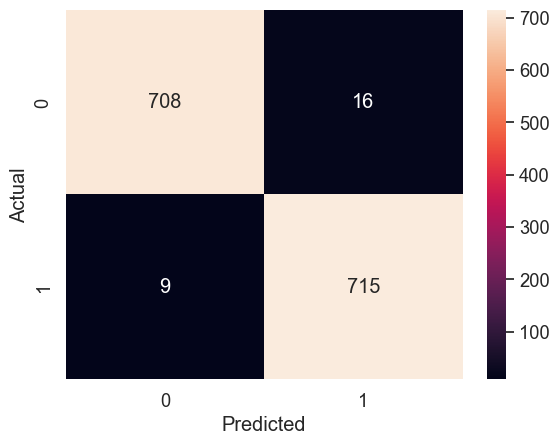

In [89]:
sns.heatmap(cm_up, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [90]:
up = classification_report(y_test_up, y_predict_up, target_names=['Ham', 'Spam'])
print(up)

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       724
        Spam       0.98      0.99      0.98       724

    accuracy                           0.98      1448
   macro avg       0.98      0.98      0.98      1448
weighted avg       0.98      0.98      0.98      1448



In [91]:
# Detection of examples
up_inf = model.predict(reviews)
up_inf

1/1 [==============================] - 0s 48ms/step


array([[0.21406454],
       [0.7806962 ],
       [0.7113453 ],
       [0.7660223 ],
       [0.00785503]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Upsampled Data)
<a class="anchor" id="9"></a>
[Table of Contents](#0.1)

In [92]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='up_model'
)

# Perform hyperparameter tuning
tuner.search(X_train_up, y_train_up, epochs=5, validation_data=(X_val_up, y_val_up))

# Get the best model
best_model_up = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\up_model\tuner0.json
CPU times: total: 812 ms
Wall time: 2.2 s


In [93]:
# Evaluate the best model on the validation set
hp_results_val_up = best_model_up.evaluate(X_val_up, y_val_up)
print(f"\nValidation Loss: {hp_results_val_up[0]}")
print(f"Validation Accuracy: {hp_results_val_up[1]}")

46/46 [==============================] - 21s 424ms/step - loss: 0.2839 - accuracy: 0.9592 - precision: 0.9819 - recall: 0.9357

Validation Loss: 0.28387752175331116
Validation Accuracy: 0.9592400789260864


In [94]:
# Evaluate the best model on the Test set
hp_results_test_up = best_model_up.evaluate(X_test_up, y_test_up)
print(f"\Test Loss: {hp_results_test_up[0]}")
print(f"Test Accuracy: {hp_results_test_up[1]}")

46/46 [==============================] - 20s 425ms/step - loss: 0.3052 - accuracy: 0.9289 - precision: 0.9829 - recall: 0.8729
\Test Loss: 0.3051791191101074
Test Accuracy: 0.9288673996925354


## Model Building
<a class="anchor" id="9.1"></a>
[Table of Contents](#0.1)

In [95]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_up.fit(X_train_up, y_train_up, epochs=20, 
                    validation_data=(X_val_up, y_val_up), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
212/212 [==============================] - 115s 528ms/step - loss: 0.1590 - accuracy: 0.9442 - precision: 0.9446 - recall: 0.9438 - val_loss: 0.1823 - val_accuracy: 0.9302 - val_precision: 0.8793 - val_recall: 0.9972 - lr: 0.0100
Epoch 2/20
212/212 [==============================] - 113s 532ms/step - loss: 0.1397 - accuracy: 0.9482 - precision: 0.9487 - recall: 0.9476 - val_loss: 0.0907 - val_accuracy: 0.9682 - val_precision: 0.9971 - val_recall: 0.9391 - lr: 0.0100
Epoch 3/20
212/212 [==============================] - 112s 529ms/step - loss: 0.1398 - accuracy: 0.9510 - precision: 0.9533 - recall: 0.9485 - val_loss: 0.5105 - val_accuracy: 0.7630 - val_precision: 0.6782 - val_recall: 1.0000 - lr: 0.0100
Epoch 4/20
212/212 [==============================] - 110s 520ms/step - loss: 0.1400 - accuracy: 0.9491 - precision: 0.9496 - recall: 0.9485 - val_loss: 0.0769 - val_accuracy: 0.9730 - val_precision: 0.9817 - val_recall: 0.9640 - lr: 0.0100
Epoch 5/20
212/212 [================

## Model Evaluation
<a class="anchor" id="9.2"></a>
[Table of Contents](#0.1)

In [96]:
y_predict_hp_up = best_model_up.predict(X_test_up)
y_predict_hp_up = y_predict_hp_up.flatten()

46/46 [==============================] - 20s 421ms/step


In [97]:
y_predict_hp_up = np.where(y_predict_hp_up > 0.5,1,0)
y_predict_hp_up

array([1, 1, 1, ..., 1, 0, 1])

In [98]:
cm_hp_up = confusion_matrix(y_test_up, y_predict_hp_up)
cm_hp_up

array([[708,  16],
       [  8, 716]], dtype=int64)

Text(43.25, 0.5, 'Actual')

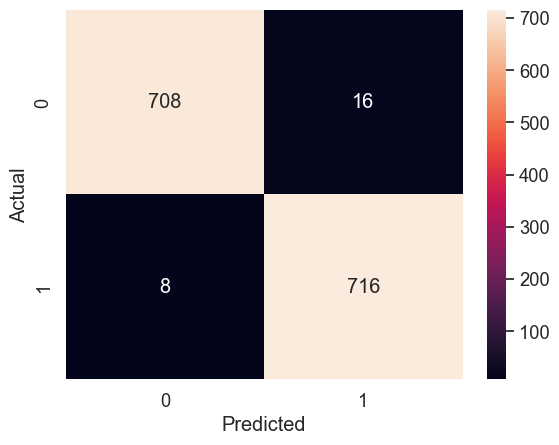

In [99]:
sns.heatmap(cm_hp_up, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [100]:
up_hp = classification_report(y_test_up, y_predict_hp_up, target_names=['Ham', 'Spam'])
print(up_hp)

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       724
        Spam       0.98      0.99      0.98       724

    accuracy                           0.98      1448
   macro avg       0.98      0.98      0.98      1448
weighted avg       0.98      0.98      0.98      1448



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="9.3"></a>
[Table of Contents](#0.1)

In [101]:
roc_auc_test = roc_auc_score(y_test_up, y_predict_hp_up)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9834


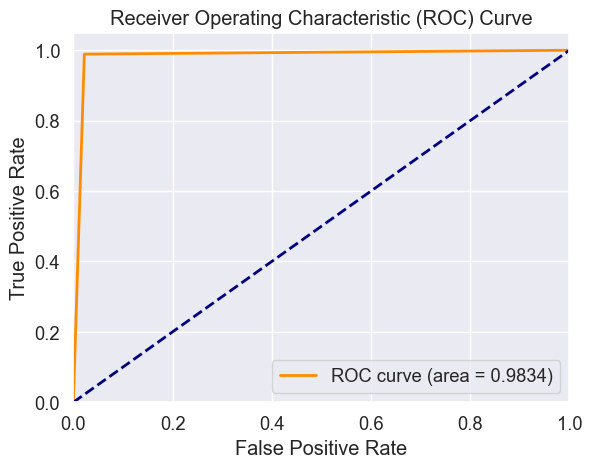

In [102]:
# y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test_up, y_predict_hp_up)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
# Detection of examples
up_inf_hp = best_model_up.predict(reviews)
up_inf_hp

1/1 [==============================] - 1s 746ms/step


array([[0.36807302],
       [0.89284533],
       [0.7597308 ],
       [0.90501106],
       [0.00621142]], dtype=float32)

## Class Weights
<a class="anchor" id="10"></a>
[Table of Contents](#0.1)

In [104]:
# Calculate class weights
class_weights = {
    0: len(y_train) / (2 * (len(y_train) - np.sum(y_train))),  # Weight for ham
    1: len(y_train) / (2 * np.sum(y_train))  # Weight for spam
}


In [105]:
%%time
clw_model = tf.keras.models.clone_model(model)

CPU times: total: 10.2 s
Wall time: 11.5 s


In [106]:
# Compile the model with class weights
clw_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics = metrics)

## Model Building
<a class="anchor" id="10.1"></a>
[Table of Contents](#0.1)

In [107]:
%%time
# Fit the model
history_clw = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    class_weight=class_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 68s 543ms/step - loss: 0.3629 - accuracy: 0.7838 - precision: 0.3827 - recall: 0.9981 - val_loss: 0.1253 - val_accuracy: 0.9605 - val_precision: 0.7762 - val_recall: 0.9911 - lr: 4.0000e-04
Epoch 2/20
122/122 [==============================] - 65s 534ms/step - loss: 0.1899 - accuracy: 0.8808 - precision: 0.5297 - recall: 0.9885 - val_loss: 0.1105 - val_accuracy: 0.9797 - val_precision: 0.8740 - val_recall: 0.9911 - lr: 4.0000e-04
Epoch 3/20
122/122 [==============================] - 72s 592ms/step - loss: 0.1398 - accuracy: 0.9382 - precision: 0.6911 - recall: 0.9751 - val_loss: 0.0931 - val_accuracy: 0.9833 - val_precision: 0.8952 - val_recall: 0.9911 - lr: 4.0000e-04
Epoch 4/20
122/122 [==============================] - 64s 527ms/step - loss: 0.1366 - accuracy: 0.9523 - precision: 0.7519 - recall: 0.9618 - val_loss: 0.0849 - val_accuracy: 0.9844 - val_precision: 0.9024 - val_recall: 0.9911 - lr: 4.0000e-04
Epoch 5/20
122/122 [====

## Model Evaluation
<a class="anchor" id="10.2"></a>
[Table of Contents](#0.1)

In [108]:
# Evaluate the model
results_clw = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

27/27 [==============================] - 11s 413ms/step - loss: 0.0506 - accuracy: 0.9904 - precision: 0.9483 - recall: 0.9821
Test Loss: 0.04175851494073868
Test Accuracy: 0.9904305934906006


In [109]:
y_predict_clw = clw_model.predict(X_test)
y_predict_clw = y_predict_clw.flatten()

27/27 [==============================] - 12s 414ms/step


In [110]:
y_predict_clw = np.where(y_predict_clw > 0.5,1,0)
y_predict_clw

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [111]:
clw_cm = confusion_matrix(y_test, y_predict)
clw_cm

array([[722,   2],
       [  6, 106]], dtype=int64)

Text(43.25, 0.5, 'Actual')

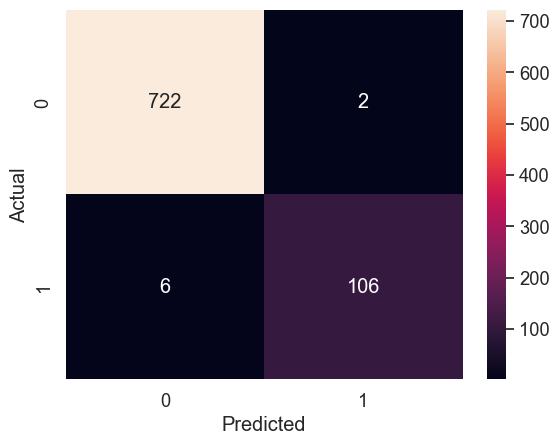

In [112]:
sns.heatmap(clw_cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [113]:
clw = classification_report(y_test, y_predict_clw, target_names=['Ham', 'Spam'])
print(clw)

              precision    recall  f1-score   support

         Ham       1.00      0.02      0.04       724
        Spam       0.14      1.00      0.24       112

    accuracy                           0.15       836
   macro avg       0.57      0.51      0.14       836
weighted avg       0.88      0.15      0.07       836



In [114]:
# Detection of examples
clw_inf = clw_model.predict(reviews)
clw_inf

1/1 [==============================] - 1s 753ms/step


array([[0.627704  ],
       [0.6396768 ],
       [0.52495974],
       [0.59353304],
       [0.5944877 ]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Class Weights)
<a class="anchor" id="11"></a>
[Table of Contents](#0.1)

In [115]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='clw_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_clw = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 02m 15s]
val_accuracy: 0.9844497442245483

Best val_accuracy So Far: 0.9844497442245483
Total elapsed time: 00h 06m 52s
CPU times: total: 4min 45s
Wall time: 6min 53s


In [116]:
# Evaluate the best model on the validation set
hp_results_val_clw = best_model_clw.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val_clw[0]}")
print(f"Validation Accuracy: {hp_results_val_clw[1]}")

27/27 [==============================] - 12s 413ms/step - loss: 0.0379 - accuracy: 0.9844 - precision: 0.9760 - recall: 0.9062

Validation Loss: 0.03790128976106644
Validation Accuracy: 0.9844497442245483


In [117]:
# Evaluate the best model on the test set
hp_results_test_clw = best_model_clw.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test_clw[0]}")
print(f"Test Accuracy: {hp_results_test_clw[1]}")

27/27 [==============================] - 11s 410ms/step - loss: 0.0407 - accuracy: 0.9844 - precision: 0.9806 - recall: 0.9018
\Test Loss: 0.04074835404753685
Test Accuracy: 0.9844497442245483


## Model Building 
<a class="anchor" id="11.1"></a>
[Table of Contents](#0.1)

In [118]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_clw.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 66s 522ms/step - loss: 0.0699 - accuracy: 0.9767 - precision: 0.9390 - recall: 0.8834 - val_loss: 0.0334 - val_accuracy: 0.9868 - val_precision: 0.9810 - val_recall: 0.9196 - lr: 0.0010
Epoch 2/20
122/122 [==============================] - 64s 527ms/step - loss: 0.0674 - accuracy: 0.9751 - precision: 0.9193 - recall: 0.8929 - val_loss: 0.0356 - val_accuracy: 0.9856 - val_precision: 0.9808 - val_recall: 0.9107 - lr: 0.0010
Epoch 3/20
122/122 [==============================] - 64s 525ms/step - loss: 0.0822 - accuracy: 0.9708 - precision: 0.9098 - recall: 0.8681 - val_loss: 0.0361 - val_accuracy: 0.9856 - val_precision: 0.9808 - val_recall: 0.9107 - lr: 0.0010
Epoch 4/20
122/122 [==============================] - 65s 531ms/step - loss: 0.0761 - accuracy: 0.9731 - precision: 0.9098 - recall: 0.8872 - val_loss: 0.0350 - val_accuracy: 0.9844 - val_precision: 0.9714 - val_recall: 0.9107 - lr: 2.0000e-04
CPU times: total: 2min 59s
Wall time

## Model Evaluation
<a class="anchor" id="11.2"></a>
[Table of Contents](#0.1)

In [119]:
y_predict_hp_clw = best_model_clw.predict(X_test)
y_predict_hp_clw = y_predict_hp_clw.flatten()

27/27 [==============================] - 12s 430ms/step


In [120]:
y_predict_hp_clw = np.where(y_predict_hp_clw > 0.5,1,0)
y_predict_hp_clw

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [121]:
cm_hp_clw = confusion_matrix(y_test, y_predict_hp_clw)
cm_hp_clw

array([[722,   2],
       [  8, 104]], dtype=int64)

Text(43.25, 0.5, 'Actual')

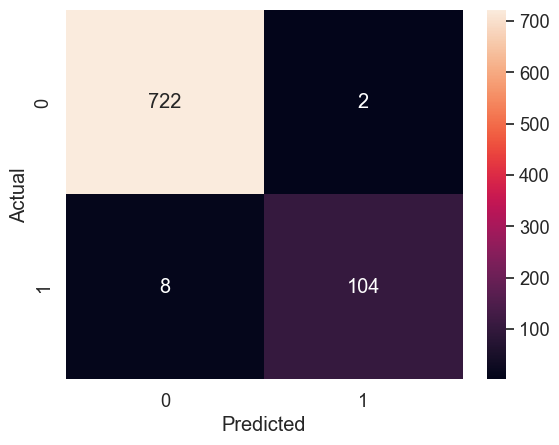

In [122]:
sns.heatmap(cm_hp_clw, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [123]:
cus_hp = classification_report(y_test, y_predict_hp_clw, target_names=['Ham', 'Spam'])
print(cus_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       724
        Spam       0.98      0.93      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="11.3"></a>
[Table of Contents](#0.1)

In [124]:
roc_auc_test = roc_auc_score(y_test, y_predict_hp_clw)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9629


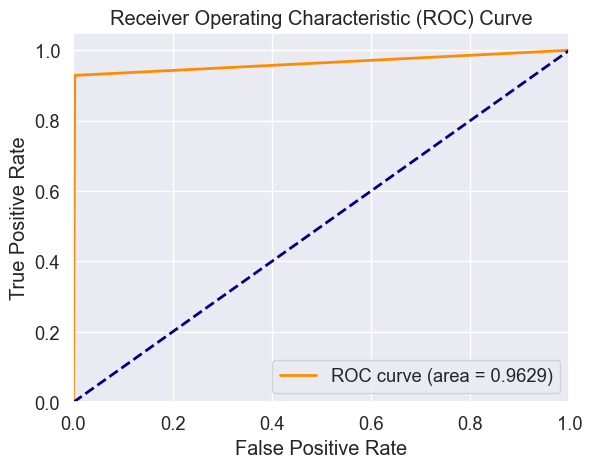

In [125]:
# Assuming y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp_clw)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [126]:
# Detection of examples
clw_inf_hp = best_model_clw.predict(reviews)
clw_inf_hp

1/1 [==============================] - 1s 824ms/step


array([[0.03164164],
       [0.43615294],
       [0.15338531],
       [0.39281282],
       [0.00118425]], dtype=float32)

## Custom Loss
<a class="anchor" id="12"></a>
[Table of Contents](#0.1)

In [127]:
%%time
cus_model = tf.keras.models.clone_model(model)  # Cloning the custom model architectire without learned weights

CPU times: total: 11.1 s
Wall time: 12.1 s


In [128]:
def custom_loss(y_train, y_predict):
    # Convert y_train to float
    y_train = tf.cast(y_train, tf.float32)
    
    # Apply label smoothing
    y_train_smoothed = y_train * 0.9 + 0.05

    # Compute binary cross-entropy
    bce_loss = tf.keras.losses.binary_crossentropy(y_train_smoothed, y_predict, from_logits=False)

    return bce_loss

In [129]:
%%time
cus_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss = custom_loss,
                  metrics = metrics)

CPU times: total: 0 ns
Wall time: 4.35 ms


## Model Building
<a class="anchor" id="12.1"></a>
[Table of Contents](#0.1)

In [130]:
%%time
# Fit the model
history_cus = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 66s 543ms/step - loss: 0.0699 - accuracy: 0.9751 - precision: 0.9128 - recall: 0.9006 - val_loss: 0.0343 - val_accuracy: 0.9868 - val_precision: 0.9810 - val_recall: 0.9196 - lr: 2.0000e-04
Epoch 2/20
122/122 [==============================] - 65s 532ms/step - loss: 0.0725 - accuracy: 0.9736 - precision: 0.9070 - recall: 0.8948 - val_loss: 0.0343 - val_accuracy: 0.9868 - val_precision: 0.9810 - val_recall: 0.9196 - lr: 2.0000e-04
Epoch 3/20
122/122 [==============================] - 65s 532ms/step - loss: 0.0744 - accuracy: 0.9762 - precision: 0.9216 - recall: 0.8987 - val_loss: 0.0343 - val_accuracy: 0.9868 - val_precision: 0.9633 - val_recall: 0.9375 - lr: 2.0000e-04
Epoch 4/20
122/122 [==============================] - 65s 534ms/step - loss: 0.0619 - accuracy: 0.9790 - precision: 0.9473 - recall: 0.8929 - val_loss: 0.0342 - val_accuracy: 0.9868 - val_precision: 0.9720 - val_recall: 0.9286 - lr: 4.0000e-05
Epoch 5/20
122/122 [====

## Model Evaluation
<a class="anchor" id="12.2"></a>
[Table of Contents](#0.1)

In [131]:
# Evaluate the model
results_cus = model.evaluate(X_test, y_test)
print(f"Test Loss: {results_cus[0]}")
print(f"Test Accuracy: {results_cus[1]}")

27/27 [==============================] - 12s 431ms/step - loss: 0.0346 - accuracy: 0.9892 - precision: 0.9813 - recall: 0.9375
Test Loss: 0.034644171595573425
Test Accuracy: 0.989234447479248


In [132]:
y_predict_cus = cus_model.predict(X_test)
y_predict_cus = y_predict_cus.flatten()

27/27 [==============================] - 12s 440ms/step


In [133]:
y_predict_cus = np.where(y_predict_cus > 0.5,1,0)
y_predict_cus

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [134]:
cm_cus = confusion_matrix(y_test, y_predict_cus)
cm_cus

array([[ 96, 628],
       [ 11, 101]], dtype=int64)

Text(43.25, 0.5, 'Actual')

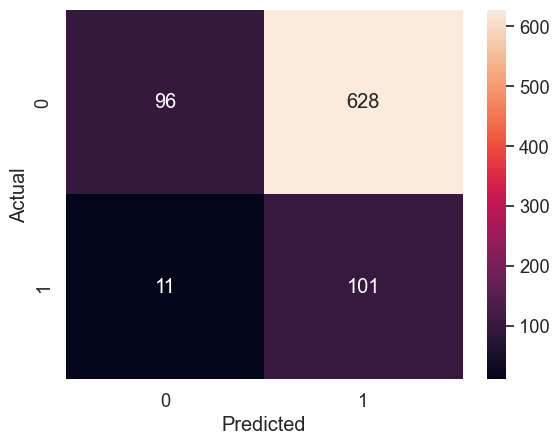

In [135]:
sns.heatmap(cm_cus, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [136]:
cus = classification_report(y_test, y_predict_cus, target_names=['Ham', 'Spam'])
print(cus)

              precision    recall  f1-score   support

         Ham       0.90      0.13      0.23       724
        Spam       0.14      0.90      0.24       112

    accuracy                           0.24       836
   macro avg       0.52      0.52      0.24       836
weighted avg       0.80      0.24      0.23       836



In [137]:
# Detection of examples
cus_inf = cus_model.predict(reviews)
cus_inf

1/1 [==============================] - 1s 947ms/step


array([[0.50201404],
       [0.5446488 ],
       [0.52540606],
       [0.53057665],
       [0.52335185]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Custom Loss)
<a class="anchor" id="13"></a>
[Table of Contents](#0.1)

In [138]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='cus_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_cus = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 02m 14s]
val_accuracy: 0.9844497442245483

Best val_accuracy So Far: 0.9868420958518982
Total elapsed time: 00h 06m 45s
CPU times: total: 4min 43s
Wall time: 6min 46s


In [139]:
# Evaluate the best model on the validation set
hp_results_val_cus = best_model_cus.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val_cus[0]}")
print(f"Validation Accuracy: {hp_results_val_cus[1]}")

27/27 [==============================] - 12s 408ms/step - loss: 0.0333 - accuracy: 0.9850 - precision: 0.9807 - recall: 0.9062

Validation Loss: 0.03334769606590271
Validation Accuracy: 0.9850478172302246


In [140]:
# Evaluate the best model on the test set
hp_results_test_cus = best_model_cus.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test_cus[0]}")
print(f"Test Accuracy: {hp_results_test_cus[1]}")

27/27 [==============================] - 11s 408ms/step - loss: 0.0349 - accuracy: 0.9880 - precision: 0.9811 - recall: 0.9286
\Test Loss: 0.03488761931657791
Test Accuracy: 0.9880383014678955


## Model Building
<a class="anchor" id="13.1"></a>
[Table of Contents](#0.1)

In [141]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_cus.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
122/122 [==============================] - 66s 518ms/step - loss: 0.0677 - accuracy: 0.9759 - precision: 0.9231 - recall: 0.8948 - val_loss: 0.0350 - val_accuracy: 0.9856 - val_precision: 0.9717 - val_recall: 0.9196 - lr: 0.0010
Epoch 2/20
122/122 [==============================] - 63s 517ms/step - loss: 0.0729 - accuracy: 0.9744 - precision: 0.9273 - recall: 0.8776 - val_loss: 0.0329 - val_accuracy: 0.9868 - val_precision: 0.9720 - val_recall: 0.9286 - lr: 0.0010
Epoch 3/20
122/122 [==============================] - 63s 514ms/step - loss: 0.0691 - accuracy: 0.9767 - precision: 0.9219 - recall: 0.9025 - val_loss: 0.0341 - val_accuracy: 0.9880 - val_precision: 0.9722 - val_recall: 0.9375 - lr: 0.0010
Epoch 4/20
122/122 [==============================] - 63s 515ms/step - loss: 0.0637 - accuracy: 0.9769 - precision: 0.9287 - recall: 0.8967 - val_loss: 0.1094 - val_accuracy: 0.9844 - val_precision: 0.9381 - val_recall: 0.9464 - lr: 0.0010
Epoch 5/20
122/122 [====================

## Model Evaluation
<a class="anchor" id="13.2"></a>
[Table of Contents](#0.1)

In [142]:
y_predict_hp_cus = best_model_cus.predict(X_test)
y_predict_hp_cus = y_predict_hp_cus.flatten()

27/27 [==============================] - 12s 413ms/step


In [143]:
y_predict_hp_cus = np.where(y_predict_hp_cus > 0.5,1,0)
y_predict_hp_cus

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [144]:
cm_hp_cus = confusion_matrix(y_test, y_predict_hp_cus)
cm_hp_cus

array([[722,   2],
       [  8, 104]], dtype=int64)

Text(43.25, 0.5, 'Actual')

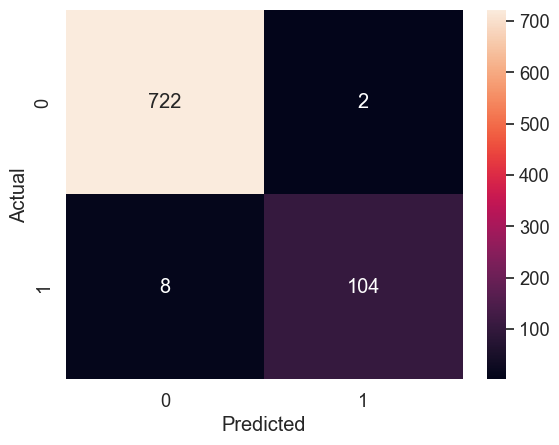

In [145]:
sns.heatmap(cm_hp_cus, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [146]:
cus_hp = classification_report(y_test, y_predict_hp_cus, target_names=['Ham', 'Spam'])
print(cus_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       724
        Spam       0.98      0.93      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="13.3"></a>
[Table of Contents](#0.1)

In [147]:
roc_auc_test = roc_auc_score(y_test, y_predict_hp_cus)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9629


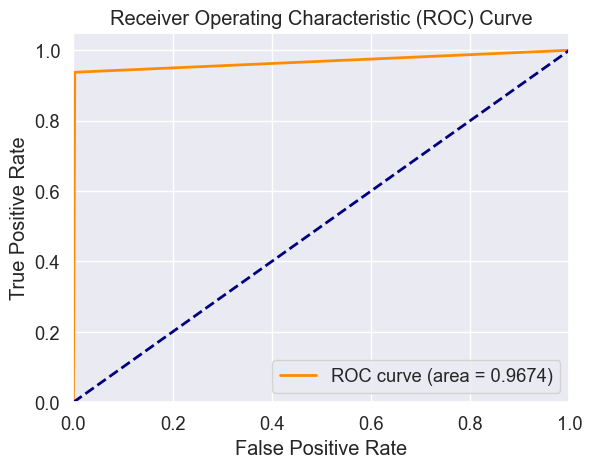

In [148]:
# y_test and y_predict_hp_cus are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [149]:
# Detection of examples
cus_inf_hp = best_model_cus.predict(reviews)
cus_inf_hp

1/1 [==============================] - 1s 697ms/step


array([[0.038733  ],
       [0.48401392],
       [0.21443476],
       [0.4764059 ],
       [0.00154567]], dtype=float32)

## Performance Comparison of Fine-Tuned BERT
<a class="anchor" id="14"></a>
[Table of Contents](#0.1)

In [151]:
# Converting the actual classification report metrics into dictionaries
nml_metrics = classification_report(y_test, y_predict, target_names=['ham', 'spam'], output_dict=True)
dwn_metrics = classification_report(y_test_dwn, y_predict_dwn, target_names=['ham', 'spam'], output_dict=True)
up_metrics = classification_report(y_test_up, y_predict_up, target_names=['ham', 'spam'], output_dict=True)
clw_metrics = classification_report(y_test, y_predict_clw, target_names=['ham', 'spam'], output_dict=True)
cus_metrics = classification_report(y_test, y_predict_cus, target_names=['ham', 'spam'], output_dict=True)

# Create a DataFrame with the relevant metrics
metrics_df = pd.DataFrame({
    'Model': ['Original', 'Down Sampling', 'Up Sampling', 'Class Weights', 'Custom Loss'],
    'Accuracy': [nml_metrics['accuracy'], dwn_metrics['accuracy'], up_metrics['accuracy'], clw_metrics['accuracy'], cus_metrics['accuracy']],
    'Precision (ham)': [nml_metrics['ham']['precision'], dwn_metrics['ham']['precision'], up_metrics['ham']['precision'], clw_metrics['ham']['precision'], cus_metrics['ham']['precision']],
    'Precision (spam)': [nml_metrics['spam']['precision'], dwn_metrics['spam']['precision'], up_metrics['spam']['precision'], clw_metrics['spam']['precision'], cus_metrics['spam']['precision']],
    'Recall (ham)': [nml_metrics['ham']['recall'], dwn_metrics['ham']['recall'], up_metrics['ham']['recall'], clw_metrics['ham']['recall'], cus_metrics['ham']['recall']],
    'Recall (spam)': [nml_metrics['spam']['recall'], dwn_metrics['spam']['recall'], up_metrics['spam']['recall'], clw_metrics['spam']['recall'], cus_metrics['spam']['recall']],
    'F1-score (ham)': [nml_metrics['ham']['f1-score'], dwn_metrics['ham']['f1-score'], up_metrics['ham']['f1-score'], clw_metrics['ham']['f1-score'], cus_metrics['ham']['f1-score']],
    'F1-score (spam)': [nml_metrics['spam']['f1-score'], dwn_metrics['spam']['f1-score'], up_metrics['spam']['f1-score'], clw_metrics['spam']['f1-score'], cus_metrics['spam']['f1-score']],
    'Support (ham)': [nml_metrics['ham']['support'], dwn_metrics['ham']['support'], up_metrics['ham']['support'], clw_metrics['ham']['support'], cus_metrics['ham']['support']],
    'Support (spam)': [nml_metrics['spam']['support'], dwn_metrics['spam']['support'], up_metrics['spam']['support'], clw_metrics['spam']['support'], cus_metrics['spam']['support']]
})

# Display the comprehensive comparison table
metrics_df


,Model,Accuracy,Precision (ham),Precision (spam),Recall (ham),Recall (spam),F1-score (ham),F1-score (spam),Support (ham),Support (spam)
0,Original,0.990431,0.991758,0.981481,0.997238,0.946429,0.994490,0.963636,724.0,112.0
1,Down Sampling,0.960000,0.926230,1.000000,1.000000,0.919643,0.961702,0.958140,113.0,112.0
2,Up Sampling,0.982735,0.987448,0.978112,0.977901,0.987569,0.982651,0.982818,724.0,724.0
3,Class Weights,0.153110,1.000000,0.136585,0.022099,1.000000,0.043243,0.240343,724.0,112.0
4,Custom Loss,0.235646,0.897196,0.138546,0.132597,0.901786,0.231047,0.240190,724.0,112.0


## Performance Comparison of Hyperparameter-Tuned BERT
<a class="anchor" id="15"></a>
[Table of Contents](#0.1)

In [152]:
# Converting the actual classification report metrics into dictionaries
nml_metrics_hp = classification_report(y_test, y_predict_hp, target_names=['ham', 'spam'], output_dict=True)
dwn_metrics_hp = classification_report(y_test_dwn, y_predict_hp_dwn, target_names=['ham', 'spam'], output_dict=True)
up_metrics_hp = classification_report(y_test_up, y_predict_hp_up, target_names=['ham', 'spam'], output_dict=True)
clw_metrics_hp = classification_report(y_test, y_predict_hp_clw, target_names=['ham', 'spam'], output_dict=True)
cus_metrics_hp = classification_report(y_test, y_predict_hp_cus, target_names=['ham', 'spam'], output_dict=True)

# Create a DataFrame with the relevant metrics
metrics_hp_df = pd.DataFrame({
    'Model': ['Original', 'Down Sampling', 'Up Sampling', 'Class Weights', 'Custom Loss'],
    'Accuracy': [nml_metrics_hp['accuracy'], dwn_metrics_hp['accuracy'], up_metrics_hp['accuracy'], clw_metrics_hp['accuracy'], cus_metrics_hp['accuracy']],
    'Precision (ham)': [nml_metrics_hp['ham']['precision'], dwn_metrics_hp['ham']['precision'], up_metrics_hp['ham']['precision'], clw_metrics_hp['ham']['precision'], cus_metrics_hp['ham']['precision']],
    'Precision (spam)': [nml_metrics_hp['spam']['precision'], dwn_metrics_hp['spam']['precision'], up_metrics_hp['spam']['precision'], clw_metrics_hp['spam']['precision'], cus_metrics_hp['spam']['precision']],
    'Recall (ham)': [nml_metrics_hp['ham']['recall'], dwn_metrics_hp['ham']['recall'], up_metrics_hp['ham']['recall'], clw_metrics_hp['ham']['recall'], cus_metrics_hp['ham']['recall']],
    'Recall (spam)': [nml_metrics_hp['spam']['recall'], dwn_metrics_hp['spam']['recall'], up_metrics_hp['spam']['recall'], clw_metrics_hp['spam']['recall'], cus_metrics_hp['spam']['recall']],
    'F1-score (ham)': [nml_metrics_hp['ham']['f1-score'], dwn_metrics_hp['ham']['f1-score'], up_metrics_hp['ham']['f1-score'], clw_metrics_hp['ham']['f1-score'], cus_metrics_hp['ham']['f1-score']],
    'F1-score (spam)': [nml_metrics_hp['spam']['f1-score'], dwn_metrics_hp['spam']['f1-score'], up_metrics_hp['spam']['f1-score'], clw_metrics_hp['spam']['f1-score'], cus_metrics_hp['spam']['f1-score']],
    'Support (ham)': [nml_metrics_hp['ham']['support'], dwn_metrics_hp['ham']['support'], up_metrics_hp['ham']['support'], clw_metrics_hp['ham']['support'], cus_metrics_hp['ham']['support']],
    'Support (spam)': [nml_metrics_hp['spam']['support'], dwn_metrics_hp['spam']['support'], up_metrics_hp['spam']['support'], clw_metrics_hp['spam']['support'], cus_metrics_hp['spam']['support']]
})

# Display the comprehensive comparison table
metrics_hp_df


,Model,Accuracy,Precision (ham),Precision (spam),Recall (ham),Recall (spam),F1-score (ham),F1-score (spam),Support (ham),Support (spam)
0,Original,0.989234,0.990398,0.981308,0.997238,0.937500,0.993806,0.958904,724.0,112.0
1,Down Sampling,0.964444,0.956522,0.972727,0.973451,0.955357,0.964912,0.963964,113.0,112.0
2,Up Sampling,0.983425,0.988827,0.978142,0.977901,0.988950,0.983333,0.983516,724.0,724.0
3,Class Weights,0.988038,0.989041,0.981132,0.997238,0.928571,0.993122,0.954128,724.0,112.0
4,Custom Loss,0.988038,0.989041,0.981132,0.997238,0.928571,0.993122,0.954128,724.0,112.0


## Inference Comparison of Fine-Tuned BERT
<a class="anchor" id="16"></a>
[Table of Contents](#0.1)

In [153]:
# Reshape arrays to be 1-dimensional
nml_inf = nml_inf.reshape(-1)
dwn_inf = dwn_inf.reshape(-1)
up_inf = up_inf.reshape(-1)
clw_inf = clw_inf.reshape(-1)
cus_inf = cus_inf.reshape(-1)

inferences = {
    'Normal Inference': nml_inf,
    'Down Sampling Inference': dwn_inf,
    'Up Sampling Inference': up_inf,
    'Class Weights Inference': clw_inf,
    'Custom Loss Inference': cus_inf
}

inf = pd.DataFrame(inferences)

# Display the table
inf

,Normal Inference,Down Sampling Inference,Up Sampling Inference,Class Weights Inference,Custom Loss Inference
0,0.027743,0.007487,0.214065,0.627704,0.502014
1,0.462971,0.210188,0.780696,0.639677,0.544649
2,0.155890,0.087669,0.711345,0.524960,0.525406
3,0.420343,0.207842,0.766022,0.593533,0.530577
4,0.007806,0.002023,0.007855,0.594488,0.523352


## Inference Comparison of Hyperparameter-Tuned BERT
<a class="anchor" id="17"></a>
[Table of Contents](#0.1)

In [154]:
# Reshape arrays to be 1-dimensional
nml_inf_hp = nml_inf_hp.reshape(-1)
dwn_inf_hp = dwn_inf_hp.reshape(-1)
up_inf_hp = up_inf_hp.reshape(-1)
clw_inf_hp = clw_inf_hp.reshape(-1)
cus_inf_hp = cus_inf_hp.reshape(-1)

inferences_hp = {
    'Normal Inference': nml_inf_hp,
    'Down Sampling Inference': dwn_inf_hp,
    'Up Sampling Inference': up_inf_hp,
    'Class Weights Inference': clw_inf_hp,
    'Custom Loss Inference': cus_inf_hp
}

inf_up = pd.DataFrame(inferences_hp)

# Display the table
inf_up

,Normal Inference,Down Sampling Inference,Up Sampling Inference,Class Weights Inference,Custom Loss Inference
0,0.021727,0.047020,0.368073,0.031642,0.038733
1,0.396931,0.444924,0.892845,0.436153,0.484014
2,0.200549,0.802365,0.759731,0.153385,0.214435
3,0.358744,0.768852,0.905011,0.392813,0.476406
4,0.004297,0.000901,0.006211,0.001184,0.001546


## Conclusion
<a class="anchor" id="18"></a>
[Table of Contents](#0.1)

Based on the comparison of the `Fine-tuned BERT model` and the `Hyperparameter-tuned BERT model` for spam detection, it is evident that the `Hyperparameter-tuned BERT model` with `Up Sampling` demonstrates the highest F1-score for spam detection, achieving a value of 0.983516. In contrast, the `Hyperparameter-tuned BERT model` with `Down Sampling` also performs well, with an F1-score of 0.963964, but it slightly falls short compared to the hyperparameter-tuned model. Other approaches, such as `Class Weights`, where weights are assigned to the data, show significantly lower F1-scores. Similarly, `Custom Loss`, which involves label smoothing according to the data labels ratio, decreases the classification report metrics, indicating less effectiveness in spam detection.

This indicates that balanced data will give more accurate results in the classification of text messages into ham or spam while applying Bidirectional Encoder Representation from Transformers (BERT). It also highlights a superior balance between precision and recall for identifying spam, making the `Hyperparameter-tuned BERT model` with `Up Sampling` the most effective model among those tested.

Given these results, the `Hyperparameter-tuned BERT model` with `Up Sampling` is recommended for optimal spam detection performance. This model is well-suited for real industry applications and is ready to be deployed. By saving this best-performing model, robust and reliable spam detection can be ensured in a production environment, enhancing the overall effectiveness and efficiency of the system.

## Deployment
<a class="anchor" id="19"></a>
[Table of Contents](#0.1)

In [ ]:
# Save the entire model to a HDF5 file
best_model_up.save('spam_detection_model.h5')


In [ ]:
# Save the model in SavedModel format
best_model_up.save('saved_model/spam_detection_model')

In [ ]:
message = input("Enter your message: ")

# Preprocess the message
preprocessed_message = bert_preprocessor([message])
encoded_message = bert_encoder(preprocessed_message)

# Predict using the best model
result = best_model_up.predict(encoded_message)
print(result)

if result[0] == 1:
    print("This has a high probability of being a spam message.")
else:
    print("This is not likely to be a spam message.")


## References
<a class="anchor" id="20"></a>
[Table of Contents](#0.1)

`www.google.com`  `www.stackoverflow.com`  `www.tensorflowhub.com`  `www.geeksforgeeks.com`  `www.youtube.com`  `www.copilot.com`  `www.chatgpt.com`